## Data Pipeline

### Steps Overview

Dataset Organization: Directory structure

```plaintext
data/raw/
├── Calc-Test_P_00038_LEFT_CC/
│   └── .../1-1.dcm         (full mammogram image)
├── Calc-Test_P_00038_LEFT_CC_1/
│   └── .../1-1.dcm, 1-2.dcm (ROI mask images)
```

1. Scan DICOM Files: 
   - Recursively collects full mammogram and ROI mask `.dcm` files from `data/raw/`.
   - Input: data/raw/
   - Output: List of file paths (full_mammo, roi_masks)
2. Extract Metadata: 
   - Parses abnormality type, patient ID, laterality, and view from folder names.
   - Input: file paths
   - Output: structured dictionary per DICOM
3. Pair Images and Masks: 
   - Matches each full mammogram to its corresponding ROI masks.
   - Input: lists from Step 1
   - Output: paired image-mask metadata
4. Consolidate Clinical Metadata: 
   - Merges multiple CSVs (calc and mass cases) into one DataFrame.
   - Input: data/metadata/ CSV files
   - Output: consolidated clinical metadata
5. Merge Metadata: 
   - Combines image-mask metadata with clinical metadata, exports to a CSV.
   - Input: outputs of Step 3 and Step 4
   - Output: cbis_ddsm_metadata_full.csv
6. Build TensorFlow Dataset: 
   - Creates a `tf.data.Dataset` with preprocessing for model training.
   - Input: final metadata CSV
   - Output: TensorFlow-ready dataset (train_ds, val_ds)

### Scan DICOM Files

- Recursively scan all .dcm files from `base_dir`.
- Separate into full mammogram images and ROI mask images.

- Args:
  - base_dir (str): Root directory containing DICOM folders (e.g., "data/raw/").

- Returns:
  - dict: {
    - "full_mammo": [list of full mammogram DICOM paths],
    - "roi_masks": [list of ROI mask DICOM paths] }

In [1]:
import os
from pathlib import Path
from typing import Dict, List

def scan_dicom_files(base_dir: str) -> Dict[str, List[str]]:
    base_path = Path(base_dir)
    dicom_files = {
        "full_mammo": [],
        "roi_masks": [],
    }

    if not base_path.exists():
        raise ValueError(f"Provided base directory does not exist: {base_dir}")

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".dcm"):
                file_path = Path(root) / file
                lower_root = str(root).lower()

                if "full mammogram images" in lower_root:
                    dicom_files["full_mammo"].append(str(file_path))
                elif "roi mask images" in lower_root:
                    dicom_files["roi_masks"].append(str(file_path))

    print(f"[INFO] Found {len(dicom_files['full_mammo'])} full mammogram DICOMs.")
    print(f"[INFO] Found {len(dicom_files['roi_masks'])} ROI mask DICOMs.")

    return dicom_files

In [2]:
base_dir = "../data/raw/"
dicom_paths = scan_dicom_files(base_dir)

# Access full mammograms and ROI masks
full_mammo_files = dicom_paths["full_mammo"]
roi_mask_files = dicom_paths["roi_masks"]

# Preview first few rows
print("\nExample full mammogram paths:")
for path in full_mammo_files[:3]:
    print(path)

print("\nExample ROI mask paths:")
for path in roi_mask_files[:3]:
    print(path)

[INFO] Found 3103 full mammogram DICOMs.
[INFO] Found 7026 ROI mask DICOMs.

Example full mammogram paths:
../data/raw/Mass-Training_P_00703_LEFT_MLO/07-20-2016-DDSM-NA-61997/1.000000-full mammogram images-53492/1-1.dcm
../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2016-DDSM-NA-68501/1.000000-full mammogram images-70245/1-1.dcm
../data/raw/Calc-Training_P_01885_LEFT_CC/08-07-2016-DDSM-NA-52613/1.000000-full mammogram images-62072/1-1.dcm

Example ROI mask paths:
../data/raw/Calc-Training_P_00991_LEFT_CC_1/09-06-2017-DDSM-NA-27663/1.000000-ROI mask images-14569/1-2.dcm
../data/raw/Calc-Training_P_00991_LEFT_CC_1/09-06-2017-DDSM-NA-27663/1.000000-ROI mask images-14569/1-1.dcm
../data/raw/Mass-Training_P_01844_RIGHT_MLO_1/07-21-2016-DDSM-NA-18197/1.000000-ROI mask images-88016/1-2.dcm


### Extract Metadata from File Paths

- Extracts abnormality type, patient ID, laterality, and view from CBIS-DDSM DICOM file path.

- Args:
  - path (str or Path): Full path to a DICOM file.

- Returns:
  - dict: { 
      - "abnormality_type": "Calc" or "Mass",
      - "patient_id": "00038",
      - "laterality": "LEFT" or "RIGHT",
      - "view": "CC" or "MLO",
      - "path": full file path (str) }
  - If parsing fails, returns None for the fields.

In [3]:
import re
from pathlib import Path
from typing import Union, Dict

# Extract abnormality type, patient ID, laterality, view from any DICOM path 
# by searching path parts for the folder name.
def extract_metadata_from_path(path: Union[str, Path]) -> Dict[str, Union[str, None]]:
    path = Path(path)

    # Try to find the folder matching "Calc-..." or "Mass-..." with pattern
    for part in path.parts:
        pattern = r"^(Calc|Mass)-(Test|Training)_P_(\d+)_([A-Z]+)_(CC|MLO)"
        match = re.match(pattern, part)
        if match:
            abnormality_type, dataset_split, patient_id, laterality, view = match.groups()
            return {
                "abnormality_type": abnormality_type,
                "patient_id": patient_id,
                "laterality": laterality,
                "view": view,
                "path": str(path)
            }
    
    # If no match found
    return {
        "abnormality_type": None,
        "patient_id": None,
        "laterality": None,
        "view": None,
        "path": str(path)
    }

In [4]:
dicom_path = "../data/raw/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-NA-96009/1.000000-full mammogram images-63992/1-1.dcm"

metadata = extract_metadata_from_path(dicom_path)

print("Extracted Metadata:")
for key, value in metadata.items():
    print(f"{key}: {value}")

Extracted Metadata:
abnormality_type: Calc
patient_id: 00038
laterality: LEFT
view: CC
path: ../data/raw/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-NA-96009/1.000000-full mammogram images-63992/1-1.dcm


### Pair Images and Masks

- Pairs full mammogram images with corresponding ROI mask images based on naming convention.

- Args:
  - full_mammo_paths (List[str]): List of full mammogram DICOM paths.
  - roi_mask_paths (List[str]): List of ROI mask DICOM paths.

- Returns:
  - List[Dict[str, str]]: List of dictionaries with keys:
    - abnormality_type
    - patient_id
    - laterality
    - view
    - image_path
    - mask_path

In [5]:
from pathlib import Path
from collections import defaultdict
import re

# Extracts a base key like 'Calc-Test_P_00038_LEFT_CC' or 'Mass-Test_P_00123_RIGHT_MLO'
# from a DICOM file path, ignoring mask/image folder suffixes.
# Args: path (str): Full DICOM file path.
# Returns: str: Standardized base key for pairing (patient_id + view + laterality).
def get_base_key(path: str) -> str:
    path = Path(path)

    # Search for the correct part
    for part in path.parts:
        pattern = r"^(Calc|Mass)-(Test|Training)_P_(\d+)_([A-Z]+)_(CC|MLO)"
        match = re.match(pattern, part)
        if match:
            abnormality_type, dataset_split, patient_id, laterality, view = match.groups()
            return f"{abnormality_type}-Test_P_{patient_id}_{laterality}_{view}"
    
    # If not found, fallback
    return None


def pair_images_and_masks(full_mammo_paths, roi_mask_paths):
    grouped_masks = defaultdict(list)
    
    for mask_path in roi_mask_paths:
        base_key = get_base_key(mask_path)
        grouped_masks[base_key].append(str(mask_path))

    paired_records = []

    for image_path in full_mammo_paths:
        metadata = extract_metadata_from_path(image_path)
        base_key = get_base_key(image_path)
        mask_list = grouped_masks.get(base_key, [])

        record = metadata.copy()
        record["image_path"] = str(image_path)
        record["mask_paths"] = mask_list  # <== LIST of mask paths!
        paired_records.append(record)

    return paired_records

In [6]:
# from scan_dicom_files import scan_dicom_files
dicom_files = scan_dicom_files("../data/raw/")

full_mammo_paths = dicom_files["full_mammo"]
roi_mask_paths = dicom_files["roi_masks"]

paired_metadata = pair_images_and_masks(full_mammo_paths, roi_mask_paths)

# Convert to DataFrame and preview
import pandas as pd
df = pd.DataFrame(paired_metadata)
print(df.head())

# Optional: Save to CSV
df.to_csv("../data/processed/cbis_ddsm_metadata_paired.csv", index=False)

[INFO] Found 3103 full mammogram DICOMs.
[INFO] Found 7026 ROI mask DICOMs.
  abnormality_type patient_id laterality view  \
0             Mass      00703       LEFT  MLO   
1             Mass      01566      RIGHT   CC   
2             Calc      01885       LEFT   CC   
3             Mass      00484      RIGHT   CC   
4             Calc      00467      RIGHT  MLO   

                                                path  \
0  ../data/raw/Mass-Training_P_00703_LEFT_MLO/07-...   
1  ../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2...   
2  ../data/raw/Calc-Training_P_01885_LEFT_CC/08-0...   
3  ../data/raw/Mass-Training_P_00484_RIGHT_CC/07-...   
4  ../data/raw/Calc-Training_P_00467_RIGHT_MLO/08...   

                                          image_path  \
0  ../data/raw/Mass-Training_P_00703_LEFT_MLO/07-...   
1  ../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2...   
2  ../data/raw/Calc-Training_P_01885_LEFT_CC/08-0...   
3  ../data/raw/Mass-Training_P_00484_RIGHT_CC/07-...   
4  ../data/r

### Consolidate Clinical Metadata CSVs

The four separately provided CBIS-DDSM metadata CSV files contain critical clinical information—such as BI-RADS category, pathology, assessment, and lesion subtlety—that are not embedded in the DICOM files or their folder names.

- data/metadata/calc_case_description_test_set.csv
- data/metadata/calc_case_description_train_set.csv
- data/metadata/mass_case_description_test_set.csv
- data/metadata/mass_case_description_train_set.csv

Each rows contains the following columns:

- Patient ID: `P_00038` — Unique patient identifier.
- Breast Side: `LEFT` — Left breast.
- Image View: `CC` or `MLO` — Standard cranio-caudal or mediolateral oblique view used in mammography.
- Breast Density: `2`
- Abnormality ID: `1`
- Abnormality Type: `calcification` — Specifically dealing with microcalcifications.
- Calcification Type: `PUNCTATE-PLEOMORPHIC` — Mixed types, suggesting variable morphology.
- Calcification Distribution: `CLUSTERED` — Clustered microcalcifications, often suspicious.
- Assessment: `4` — BI-RADS 4, suspicious abnormality; biopsy usually recommended.
- Pathology: `BENIGN` — Biopsy/pathology confirmed the finding as benign.
- Subtlety: `2` — Fairly subtle (1 = very subtle, 5 = very obvious).
- Image Files:
  - Original Image Path: Full mammogram DICOM.
    Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/000000.dcm
  - Cropped Image Path: Focused region where calcifications are.
    Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/000001.dcm
  - ROI Mask Path: Binary mask of the calcifications (region of interest).
    Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/000000.dcm

The following script reads and merges the metadata CSV files, cleans weird paths, adds missing fields where needed and exports everything into a properly formatted metadata_master.csv.

In [7]:
import pandas as pd
import csv
from pathlib import Path

# Input CSV files
input_files = [
    '../data/metadata/calc_case_description_test_set.csv',
    '../data/metadata/calc_case_description_train_set.csv',
    '../data/metadata/mass_case_description_test_set.csv',
    '../data/metadata/mass_case_description_train_set.csv'
]

# Read CSVs by properly handling malformed newlines and all the data cleanly kept.
dfs = []
for file in input_files:
    df = pd.read_csv(
        file,
        engine="python",        # Use Python engine to properly handle malformed newlines
        quoting=csv.QUOTE_MINIMAL, # Respect quotes
        skip_blank_lines=True   # Optional: Skip totally blank lines
    )
    dfs.append(df)

# Concatenate all together
metadata = pd.concat(dfs, ignore_index=True)

# Rename columns
metadata = metadata.rename(columns={
    'patient_id': 'patient_id',
    'left or right breast': 'side',
    'image view': 'view',
    'abnormality id': 'abnormality_id',
    'abnormality type': 'abnormality_type',
    'calc type': 'calc_type',
    'calc distribution': 'distribution',
    'mass shape': 'mass_shape',
    'mass margins': 'mass_margins',
    'breast density': 'breast_density',
    'assessment': 'assessment',
    'pathology': 'pathology',
    'subtlety': 'subtlety',
    'image file path': 'full_mammo_path',
    'cropped image file path': 'cropped_roi_path',
    'ROI mask file path': 'roi_mask_path'
})

# Add missing columns if needed
for col in ['calc_type', 'distribution', 'mass_shape', 'mass_margins']:
    if col not in metadata.columns:
        metadata[col] = pd.NA

# Normalize file paths
def fix_path(path):
    if pd.isna(path):
        return None
    # Remove a newline character embedded inside the "cropped image file path" field.
    path = path.strip().replace('\\', '/').replace('\"', '')
    parts = Path(path).parts
    if len(parts) < 4:
        return path
    parent_folder = parts[0]
    subfolder = parts[1]
    file_name = parts[-1]
    return f'raw/{parent_folder}/{subfolder}/{file_name}'

# Apply path fixing
for col in ['full_mammo_path', 'cropped_roi_path', 'roi_mask_path']:
    metadata[col] = metadata[col].apply(fix_path)

# Select final columns
final_cols = [
    'patient_id', 'breast_density', 'side', 'view', 'abnormality_id',
    'abnormality_type', 'calc_type', 'distribution', 'mass_shape', 'mass_margins',
    'assessment', 'pathology', 'subtlety',
    'full_mammo_path', 'cropped_roi_path', 'roi_mask_path'
]
metadata = metadata[final_cols]

# Save to CSV
output_path = '../data/metadata/metadata_master.csv'
metadata.to_csv(output_path, index=False)
print(f'Master metadata CSV created: {output_path}')

Master metadata CSV created: ../data/metadata/metadata_master.csv


### Merge Image–Mask Metadata and Clinical Metadata

- Merge paired image–mask metadata with clinical metadata based on patient_id, view, laterality, and abnormality_id.

- Args:
  - paired_metadata_path (str): Path to the paired image-mask metadata CSV.
  - clinical_metadata_path (str): Path to the consolidated clinical metadata CSV.
  - output_path (str): Path to save the merged master metadata CSV.

- Returns:
  - pd.DataFrame: Final merged metadata DataFrame.

In [8]:
import pandas as pd
from pathlib import Path

def merge_metadata(
    paired_metadata_path: str,
    clinical_metadata_path: str,
    output_path: str
) -> pd.DataFrame:

    # Load CSVs
    paired_df = pd.read_csv(paired_metadata_path)
    clinical_df = pd.read_csv(clinical_metadata_path)

    # Normalize column names if needed
    paired_df = paired_df.rename(columns={
        'side': 'laterality'  # If needed (depending on how it was named)
    })

    # Standardize patient_id
    # Remove 'P_' prefix from clinical metadata patient IDs
    clinical_df['patient_id'] = clinical_df['patient_id'].astype(str).str.replace('P_', '').str.zfill(5)
    # Paired metadata: ensure patient_id is 5-digit zero-padded string
    paired_df['patient_id'] = paired_df['patient_id'].astype(str).str.zfill(5)

    # Ensure consistent casing for joining keys
    paired_df['laterality'] = paired_df['laterality'].astype(str).str.upper()
    paired_df['view'] = paired_df['view'].astype(str).str.upper()
    clinical_df['side'] = clinical_df['side'].astype(str).str.upper()
    clinical_df['view'] = clinical_df['view'].astype(str).str.upper()

    # Merge: LEFT JOIN, keep all paired image/mask metadata
    merged = pd.merge(
        paired_df,
        clinical_df,
        how="left",
        left_on=["patient_id", "laterality", "view"],
        right_on=["patient_id", "side", "view"]
    )

    # Drop duplicate columns (like "side" from clinical metadata)
    if "side" in merged.columns:
        merged = merged.drop(columns=["side"])

    # Add binary label from pathology if present
    if 'pathology' in merged.columns:
        merged['label'] = merged['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK':0}).astype('float32')

    # Save merged DataFrame
    output_dir = Path(output_path).parent
    output_dir.mkdir(parents=True, exist_ok=True)
    merged.to_csv(output_path, index=False)

    print(f"[INFO] Master merged metadata saved at: {output_path}")
    print(f"[INFO] Merged metadata shape: {merged.shape}")

    return merged

In [9]:
paired_metadata_path = "../data/processed/cbis_ddsm_metadata_paired.csv"
clinical_metadata_path = "../data/metadata/metadata_master.csv"
output_path = "../data/processed/cbis_ddsm_metadata_full.csv"
merged_metadata = merge_metadata(paired_metadata_path, clinical_metadata_path, output_path)

# Preview
print(merged_metadata.head())

[INFO] Master merged metadata saved at: ../data/processed/cbis_ddsm_metadata_full.csv
[INFO] Merged metadata shape: (3751, 22)
  abnormality_type_x patient_id laterality view  \
0               Mass      00703       LEFT  MLO   
1               Mass      01566      RIGHT   CC   
2               Mass      01566      RIGHT   CC   
3               Calc      01885       LEFT   CC   
4               Mass      00484      RIGHT   CC   

                                                path  \
0  ../data/raw/Mass-Training_P_00703_LEFT_MLO/07-...   
1  ../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2...   
2  ../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2...   
3  ../data/raw/Calc-Training_P_01885_LEFT_CC/08-0...   
4  ../data/raw/Mass-Training_P_00484_RIGHT_CC/07-...   

                                          image_path  \
0  ../data/raw/Mass-Training_P_00703_LEFT_MLO/07-...   
1  ../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2...   
2  ../data/raw/Mass-Test_P_01566_RIGHT_CC/10-04-2...   
3  ..

### Build TensorFlow Dataset

In [10]:
!pip uninstall tensorflow -y
!python3 -m venv .venv
!source .venv/bin/activate
!pip install tensorflow==2.15.0
# The cuXXX (CUDA) wheels are Linux-only, NVIDIA GPU-only
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# Use the official PyPI source, or the command from the PyTorch website for macOS!
!pip install torch torchvision torchaudio
!pip install pandas pydicom

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl (2.1 kB)


#### Set Parameters

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
import pydicom
import ast
import os
from pathlib import Path

# Set TensorFlow logging level to suppress warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Global configuration
INPUT_SHAPE = (512, 512, 1)
TARGET_SIZE = INPUT_SHAPE[:2]
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
#  Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Check PyTorch version and GPU availability
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
# Never use the cuXXX index for macOS!
# Use the official PyPI source, or the command from the PyTorch website.
# print("Current device:", torch.cuda.current_device())
# print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version: 2.7.0
CUDA available: False
CUDA device count: 0


#### Helper Functions

In [20]:
# DICOM Loader
# Load and normalize a DICOM image from a byte string path
def load_dicom_image(path_tensor):
    path = path_tensor.decode('utf-8')  # Decode byte string to UTF-8
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)
        img -= np.min(img)
        img /= (np.max(img) + 1e-6)  # normalize to [0,1]
    except Exception as e:
        print(f"[DICOM ERROR] {path}: {e}")
        img = np.zeros(TARGET_SIZE, dtype=np.float32)
    return img

# TensorFlow Wrappers
# Load and preprocess a single full mammogram image
def tf_load_dicom(path):
    # img = tf.numpy_function(load_dicom_image, [path], tf.float32)
    img = tf.numpy_function(func=load_dicom_image, inp=[path], Tout=tf.float32)
    img.set_shape([None, None])  # initially 2D
    img = tf.expand_dims(img, axis=-1)  # [H, W, 1]
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, TARGET_SIZE)
    return img

def tf_load_multiple_dicom(paths):
    # paths: tf.Tensor of shape [N] (string paths)
    def load_single(path):
        img = tf.numpy_function(load_dicom_image, [path], tf.float32)
        img.set_shape([None, None])
        img = tf.expand_dims(img, axis=-1)
        img.set_shape([None, None, 1])
        img = tf.image.resize(img, TARGET_SIZE)
        return img

    masks = tf.map_fn(
        load_single,
        paths,
        fn_output_signature=tf.TensorSpec(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1), dtype=tf.float32)
    )
    return tf.reduce_max(masks, axis=0)  # union of all masks

# Unified MTL Preprocessor
# Load and preprocess multiple ROI masks and combine into a single mask tensor
def load_and_preprocess(image_path, mask_paths, label):
    image = tf_load_dicom(image_path)  # (512, 512, 1)
    mask = tf_load_multiple_dicom(mask_paths)  # (512, 512, 1)
    label = tf.cast(label, tf.float32)
    return image, {"segmentation": mask, "classification": label}

# Parse a dictionary record into image + MTL target dict
def parse_record(record):
    image_path = record['image_path']
    mask_paths = record['mask_paths']
    label = record['label']

    image, target = load_and_preprocess(image_path, mask_paths, label)
    return image, target

# Build tf.data.Dataset from metadata CSV
def build_tf_dataset(
    metadata_csv: str,
    batch_size: int = 8,
    shuffle: bool = True
) -> tf.data.Dataset:

    # Load metadata CSV
    df = pd.read_csv(metadata_csv)

    # Parse stringified list of mask_paths
    df['mask_paths'] = df['mask_paths'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

    # Ensure label column is float32-compatible (e.g., 0.0, 1.0)
    df['label'] = df['label'].astype(np.float32)

    # Convert to list of dicts
    records = df[['image_path', 'mask_paths', 'label']].to_dict(orient='records')

    # Create dataset
    ds = tf.data.Dataset.from_generator(
        lambda: (r for r in records),
        output_signature={
            "image_path": tf.TensorSpec(shape=(), dtype=tf.string),
            "mask_paths": tf.TensorSpec(shape=(None,), dtype=tf.string),
            "label": tf.TensorSpec(shape=(), dtype=tf.float32),
        }
    )

    # Apply MTL-compatible mapping function
    ds = ds.map(lambda r: parse_record(r), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(records))

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [16]:
# Build dataset
train_ds = build_tf_dataset(
    metadata_csv="../data/processed/cbis_ddsm_metadata_full.csv",
    batch_size=8
)

# Preview one batch
for images, targets in train_ds.take(1):
    print(f"Images batch shape: {images.shape}")  # (8, 512, 512, 1)
    print(f"Masks batch shape: {targets['segmentation'].shape}")     # (8, 512, 512, 1)
    print(f"Labels batch shape: {targets['classification'].shape}")  # (8,)


Images batch shape: (8, 512, 512, 1)
Masks batch shape: (8, 512, 512, 1)
Labels batch shape: (8,)


The resulting train_ds is a complete TensorFlow training dataset — (image, {"segmentation": mask, "classification": label}), normalized, resized, shuffled, batched, ready for model training.

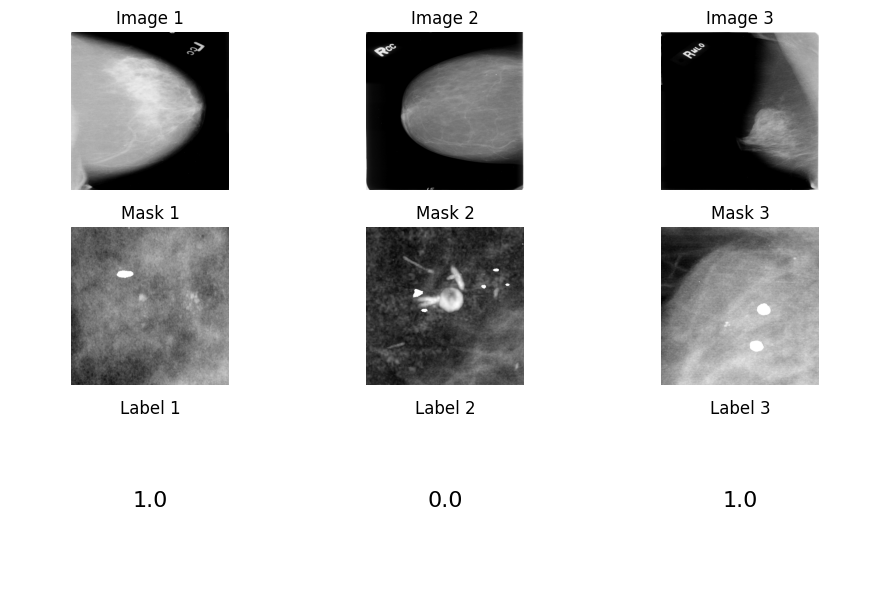

In [19]:
import matplotlib.pyplot as plt

for images, targets in train_ds.take(1):
    num_examples = 3  # Number of samples to visualize

    plt.figure(figsize=(num_examples * 3, 6))

    for i in range(num_examples):
        # Plot image
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(images[i, ..., 0], cmap="gray")
        plt.axis("off")
        plt.title(f"Image {i+1}")

        # Plot mask
        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(targets['segmentation'][i, ..., 0], cmap="gray")
        plt.axis("off")
        plt.title(f"Mask {i+1}")

        # Display the label
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        label = targets['classification'][i].numpy()
        plt.text(0.5, 0.5, str(label), fontsize=16, ha='center', va='center')
        plt.axis("off")
        plt.title(f"Label {i+1}")

    plt.tight_layout()
    plt.show()